After cleaning and engineering features, we are now finally at the part where we can do some predictions! I will be using an XGBoost regression algorithm on this data, for the following reasons:

1. XGBoost does not expect data to be linear (and as we saw in Part 2, the ICU data is very skewed)
2. XGBoost works well on large datasets, particularly where the number of rows exceeds the number of predictors
3. XGBoost is very powerful, due to its fitting of subsequent trees on residuals

We'll use randomized search to do our tuning in a sequential manner (i.e., searching for the optimal hyperparameters at a time as opposed to doing them all at once). We'll also use pyspark here so that we can use multiple cores to do our processing.

In [1]:
import scipy
import pickle
import numpy as np
from scipy import sparse

In [2]:
# load in saved data
X_train_sparse = scipy.sparse.load_npz('data/X_train_sparse.npz')
X_test_sparse = scipy.sparse.load_npz('data/X_test_sparse.npz')

In [3]:
y_train = pickle.load(open("data/y_train.txt","rb"))
y_test = pickle.load(open("data/y_test.txt","rb"))
feature_names = pickle.load(open("data/feature_names.txt","rb"))

In [4]:
params = pickle.load(open("data/tuned_params.txt","rb"))

In [5]:
params

{'min_child_weight': 3, 'max_depth': 5, 'subsample': 1.0, 'eta': 0.1}

In [8]:
#locals().update(params)

## Train XGBoost

In [6]:
import xgboost as xg
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV, GridSearchCV
from joblibspark import register_spark
from sklearn.utils import parallel_backend

### Max depth & min child weight

Max depth: maximum number of nodes in a tree. More nodes = more complex relationships (can overfit)

Min child weight: minimum weight required to create a tree. Small min child weight = fewer samples in a tree (also can cause overfitting)

These two are fit together to balance the bias-variance trade-off

In [5]:
model = xg.XGBRegressor()
max_depth = range(1, 6)
min_child_weight = range(3, 8)
param_grid = dict(max_depth = max_depth, 
                  min_child_weight = min_child_weight)

kfold = RepeatedKFold(n_splits=5, random_state=7)

gs = RandomizedSearchCV(model, param_grid, scoring = 'neg_mean_absolute_error', cv = kfold, verbose = 3, n_jobs = -1)

In [7]:
register_spark() 

In [7]:
with parallel_backend('spark', n_jobs=-1):
    gs.fit(X_train_sparse,y_train)

Fitting 50 folds for each of 10 candidates, totalling 500 fits


In [8]:
print('best score: %.2f using %s' % (gs.best_score_, gs.best_params_))

best score: -0.71 using {'min_child_weight': 3, 'max_depth': 5}


In [9]:
gs.best_params_ 

{'min_child_weight': 3, 'max_depth': 5}

In [21]:
locals().update(gs.best_params_)

In [14]:
params={}

In [16]:
params['min_child_weight']= min_child_weight

In [ ]:
params['max_depth']= max_depth

In [19]:
params

{'min_child_weight': 3, 'max_depth': 5}

### Subsample

Subsample: the fraction of observations to subsample at each boosting round. Default = 1, all rows used

In [22]:
subsample = [i/10. for i in range(7,11)]
param_grid = dict(subsample = subsample,
                 min_child_weight=[min_child_weight],
                 max_depth = [max_depth])

kfold = RepeatedKFold(n_splits=5, random_state=7)

model = xg.XGBRegressor()
gs = GridSearchCV(model, param_grid, scoring = 'neg_mean_absolute_error', cv = kfold, verbose = 2, n_jobs = -1)

In [23]:
with parallel_backend('spark', n_jobs=-1):
    gs.fit(X_train_sparse,y_train)

Fitting 50 folds for each of 4 candidates, totalling 200 fits


In [27]:
gs.best_params_

{'max_depth': 5, 'min_child_weight': 3, 'subsample': 1.0}

In [28]:
locals().update(gs.best_params_)

In [29]:
params['subsample']=subsample

### eta
eta: learning rate for each step; controls the shrinkage of weights associated with features after each round (how much to correct for at each step). Lower eta: more robust to overfitting, but requires more boosting rounds.

In [30]:
eta = [0.3, 0.2, 0.1, 0.5, 0.01, 0.005]
param_grid = dict(eta = eta,
                 subsample=[subsample],
                 min_child_weight = [min_child_weight],
                 max_depth = [max_depth])

kfold = RepeatedKFold(n_splits=5, random_state=7)

model = xg.XGBRegressor()
gs = GridSearchCV(model, param_grid, scoring = 'neg_mean_absolute_error', cv = kfold, verbose = 2, n_jobs = -1)

In [31]:
with parallel_backend('spark', n_jobs=-1):
    gs.fit(X_train_sparse,y_train)

Fitting 50 folds for each of 6 candidates, totalling 300 fits


In [32]:
gs.best_params_

{'eta': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 1.0}

In [33]:
locals().update(gs.best_params_)

In [34]:
params['eta']=eta

### reg lambda
Reg lambda: regularization parameter to shrink the number of predictors

In [9]:
reg_lambda = [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
param_grid = dict(reg_lambda = reg_lambda,
                   subsample=[subsample],
                   min_child_weight = [min_child_weight],
                   max_depth = [max_depth],
                   eta = [eta])

kfold = RepeatedKFold(n_splits=5, random_state=7)

model = xg.XGBRegressor()
gs = GridSearchCV(model, param_grid, scoring = 'neg_mean_absolute_error', cv = kfold, verbose = 2, n_jobs = -1)

In [10]:
with parallel_backend('spark', n_jobs=-1):
    gs.fit(X_train_sparse, y_train)

Fitting 50 folds for each of 6 candidates, totalling 300 fits


In [11]:
gs.best_params_

{'eta': 0.1,
 'max_depth': 5,
 'min_child_weight': 3,
 'reg_lambda': 0.1,
 'subsample': 1.0}

In [12]:
locals().update(gs.best_params_)

In [13]:
params['reg_lambda']=reg_lambda

In [14]:
with open("data/tuned_params.txt", "wb") as fp:
    pickle.dump(params, fp)

In [15]:
params['n_estimators']=999

In [16]:
params

{'min_child_weight': 3,
 'max_depth': 5,
 'subsample': 1.0,
 'eta': 0.1,
 'reg_lambda': 0.1,
 'n_estimators': 999}

### Fit XGBoost

In [17]:
xgb_r = xg.XGBRegressor(**params, objective = "reg:squarederror", seed = 31, feature_names = feature_names)

In [18]:
xgb_r

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, eta=0.1,
             feature_names=['ETHNICITY_WHITE', 'ETHNICITY_BLACK',
                            'ETHNICITY_HISPANIC/LATINO', 'ETHNICITY_ASIAN',
                            'ETHNICITY_NATIVE', 'ADMISSION_NUM', 'ICUSTAY_NUM',
                            'AGE', 'ICD_BINS_18', 'ICD_BINS_1', 'ICD_BINS_2',
                            'ICD_BINS_3', 'ICD_BINS_4', 'ICD_BINS_5',
                            'I...
             gamma=None, gpu_id=None, importance_type='gain',
             interaction_constraints=None, learning_rate=None,
             max_delta_step=None, max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=999, n_jobs=None,
             num_parallel_tree=None, random_state=None, reg_alpha=None,
             reg_lambda=0.1, scale_pos_weight=None, seed=31, subsample=1.0,
             tree_method=None, valid

In [19]:
eval_set = [(X_train_sparse, y_train), (X_test_sparse, y_test)]

In [20]:
xgb_r.fit(X_train_sparse, y_train, eval_set=eval_set, early_stopping_rounds = 10)

[19:29:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:6.67241	validation_1-rmse:6.63598
[1]	validation_0-rmse:6.07023	validation_1-rmse:6.04348
[2]	validation_0-rmse:5.52725	validation_1-rmse:5.50812
[3]	validation_0-rmse:5.04492	validation_1-rmse:5.03887
[4]	validation_0-rmse:4.60609	validation_1-rmse:4.62137
[5]	validation_0-rmse:4.21448	validation_1-rmse:4.24196
[6]	validation_0-rmse:3.85912	validation_1-rmse:3.88410
[7]	validation_0-rmse:3.54240	validation_1-rmse:3.58745
[8]	validation_0-rmse:3.26004	validation_1-rmse:3.32610
[9]	validation_0-rmse:3.00119	validation_1-rmse:3.09134
[10]	validation_0-rmse:2.77424	validation_1-rmse:2.88248
[11]	validation_0-rm

[137]	validation_0-rmse:0.56931	validation_1-rmse:1.37829
[138]	validation_0-rmse:0.56765	validation_1-rmse:1.37823
[139]	validation_0-rmse:0.56598	validation_1-rmse:1.37782
[140]	validation_0-rmse:0.56431	validation_1-rmse:1.37736
[141]	validation_0-rmse:0.56200	validation_1-rmse:1.37693
[142]	validation_0-rmse:0.56022	validation_1-rmse:1.37670
[143]	validation_0-rmse:0.55839	validation_1-rmse:1.37597
[144]	validation_0-rmse:0.55676	validation_1-rmse:1.37570
[145]	validation_0-rmse:0.55465	validation_1-rmse:1.37510
[146]	validation_0-rmse:0.55283	validation_1-rmse:1.37486
[147]	validation_0-rmse:0.55095	validation_1-rmse:1.37443
[148]	validation_0-rmse:0.54955	validation_1-rmse:1.37436
[149]	validation_0-rmse:0.54793	validation_1-rmse:1.37419
[150]	validation_0-rmse:0.54670	validation_1-rmse:1.37383
[151]	validation_0-rmse:0.54529	validation_1-rmse:1.37399
[152]	validation_0-rmse:0.54352	validation_1-rmse:1.37382
[153]	validation_0-rmse:0.54179	validation_1-rmse:1.37383
[154]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1,
             feature_names=['ETHNICITY_WHITE', 'ETHNICITY_BLACK',
                            'ETHNICITY_HISPANIC/LATINO', 'ETHNICITY_ASIAN',
                            'ETHNICITY_NATIVE', 'ADMISSION_NUM', 'ICUSTAY_NUM',
                            'AGE', 'ICD_BINS_18', 'ICD_BINS_1', 'ICD_BINS_2',
                            'ICD_BINS_3', 'ICD_BINS_4', 'ICD_BINS_5',
                            'ICD_BIN...
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=999, n_jobs=8,
             num_parallel_tree=1, random_state=31, reg_alpha=0, reg_lambda=0.1,
             scale_pos_weight=1, seed=31, subsample=1.0, tree_method='exact',
             validate_parameters

In [21]:
y_train_preds = xgb_r.predict(X_train_sparse)

In [22]:
y_test_preds = xgb_r.predict(X_test_sparse)

In [23]:
xgb_r.score(X_train_sparse,y_train)

0.9949553438402707

In [24]:
# Test R2
xgb_r.score(X_test_sparse,y_test)

0.9532896696406469

In [25]:
# Adjusted R2
1-(1-xgb_r.score(X_test_sparse,y_test))*(len(y_test)-1)/(len(y_test)-X_test_sparse.shape[1]-1)

0.9346471829992583

### View top features

In [33]:
from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(xgb_r, prefit = True)
selected_data = selection.transform(X_train_sparse)

In [27]:
#Total selected features
np.count_nonzero(xgb_r.feature_importances_)

1974

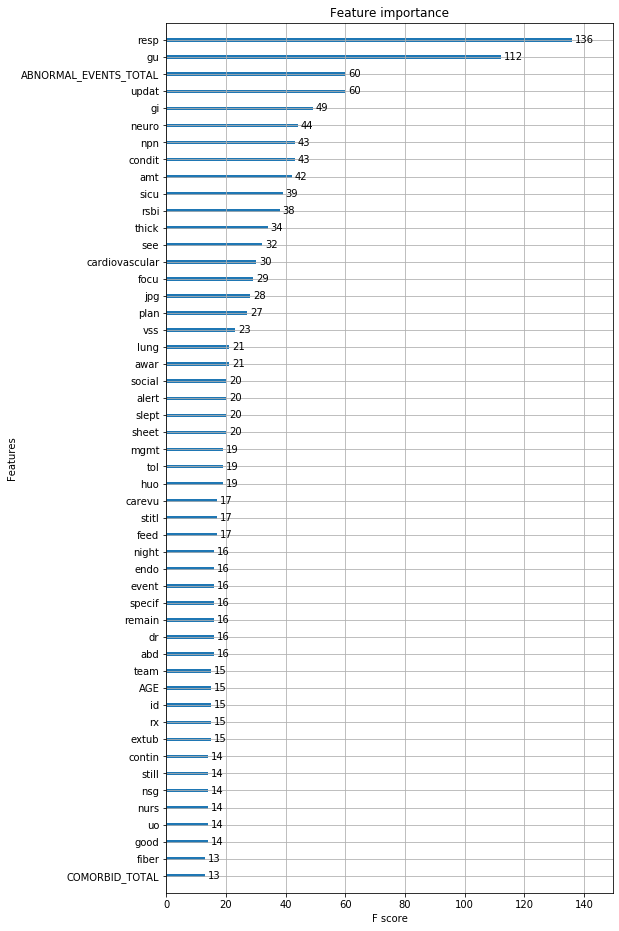

In [47]:
import xgboost as xg
import matplotlib as plt
from xgboost import plot_importance
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (8, 16)

xgb_r.get_booster().feature_names = feature_names
xg.plot_importance(xgb_r.get_booster(), max_num_features = 50)

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mean_train = np.mean(y_train)

# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train


# Compute RMSE
rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Baseline RMSE is {:.2f}".format(rmse_baseline))

# Compute MSE
mse_baseline = mean_squared_error(y_test, baseline_predictions)
print("Baseline MSE is {:.2f}".format(mse_baseline))

# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline RMSE is 6.30
Baseline MSE is 39.69
Baseline MAE is 3.44


In [43]:
rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))
print("train RMSE : % f" %(rmse)) 

mse = mean_squared_error(y_train, y_train_preds)
print("train MSE : % f" %(mse)) 

mae = mean_absolute_error(y_train, y_train_preds)
print("train MAE : % f" %(mae)) 

train RMSE :  0.451658
train MSE :  0.203995
train MAE :  0.333962


In [44]:
rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))
print("test RMSE : % f" %(rmse)) 

mse = mean_squared_error(y_test, y_test_preds)
print("test MSE : % f" %(mse)) 

mae = mean_absolute_error(y_test, y_test_preds)
print("test MAE : % f" %(mae)) 

test RMSE :  1.361579
test MSE :  1.853898
test MAE :  0.609747


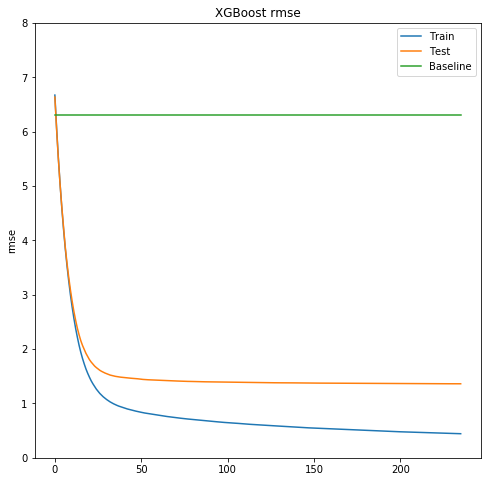

In [45]:
import matplotlib.pyplot as plt 
from matplotlib import pyplot

# make predictions for test data
predictions = [round(value) for value in y_test_preds]

# retrieve performance metrics
results = xgb_r.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
baseline_rmse_list = epochs * [rmse_baseline]

# plot log loss
fig, ax = pyplot.subplots(figsize=(8,8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.plot(x_axis, baseline_rmse_list, label='Baseline')
ax.legend()

pyplot.ylim(0,8)
pyplot.ylabel('rmse')
pyplot.title('XGBoost rmse')
pyplot.show()
